In [1]:
from collections import defaultdict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import imblearn
import sklearn.metrics as metrics
import xgboost

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, chi2, RFE, RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, plot_confusion_matrix, f1_score, recall_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#Setting up graph standards
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

* [Data Loading](#data_load)
* [Upsampling and Scaling](#up)
* [Feature Selection](#feat_selection)
    * [Method 1: SelectKBest](#selectkbest)
    * [Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features](#rfecv)
    * [Method 3: Lasso](#Lasso)
    * [Method 4: Random Forest Feature Importance](#rffi)
    * [Method 5: Mean Measurements Only](#mean)
    * [Method 6: Least Correlated](#less)

## Data loading <a class="anchor" id="data_load"></a>

In [3]:
X = pd.DataFrame(load_breast_cancer().data)
X.columns = load_breast_cancer().feature_names
y = pd.DataFrame(load_breast_cancer().target)

In [4]:
y.value_counts()

1    357
0    212
dtype: int64

In [5]:
y = y.replace({0:True, 1:False})

In [6]:
y.value_counts()

False    357
True     212
dtype: int64

In [7]:
#Splitting test/train 50/50
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (284, 30), (284, 1)
Test Data: (285, 30), (285, 1)


### Upsampling and Scaling the Data <a class="anchor" id="data_load"></a>

In [8]:
#Upsampling training data
counter = Counter(y_train)
upsample = SMOTE()
X_train, y_train = upsample.fit_resample(X_train, y_train)

print(f"Total Data after Upsampling: {len(X_train)}")
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")


Total Data after Upsampling: 340
Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)


In [9]:
y_train.value_counts()

True     170
False    170
dtype: int64

In [10]:
y.value_counts()

False    357
True     212
dtype: int64

In [11]:
y_test.value_counts()

False    187
True      98
dtype: int64

In [12]:
#Scaling train and test data
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")

Train Data: (340, 30), (340, 1)
Test Data: (285, 30), (285, 1)


#### Baseline Model 

Accuracy on test data: 0.99
ROC AUC: 99.73807704900142%


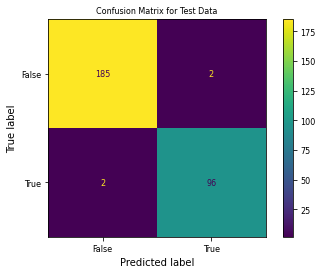

In [13]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
fs_dict = {}

# Accuray On Test Data
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"Baseline_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf, X_test, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

In order to make a simpler and more widely applicable model, I will endeavour to reduce the number of features needed for an accurate prediction.

## Feature Selection <a class="anchor" id="corr"></a>

* [Method 1: SelectKBest](#selectkbest)
* [Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features](#rfecv)
* [Method 3: Lasso](#Lasso)
* [Method 4: Random Forest Feature Importance](#rffi)
* [Method 5: Mean Measurements Only](#mean)
* [Method 6: Least Correlated](#less)

### Method 1: SelectKBest <a class="anchor" id="selectkbest"></a>

[SelectKbest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

In [14]:
selector = SelectKBest(f_classif, k=15) #chi2 requires non negative
feature_set_skb = selector.fit_transform(X_train,y_train)

In [15]:
names = X.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
SelectKbest_df = pd.DataFrame(data = names_scores, columns=['Features', 'Scores'])
SelectKbest_df = SelectKbest_df.sort_values(by='Scores', ascending= False)

In [16]:
feature_set_skb.shape

(340, 15)

In [73]:
%store feature_set_skb

Stored 'feature_set_skb' (ndarray)


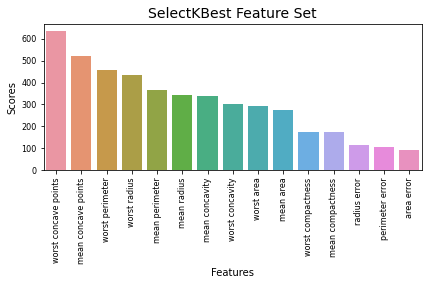

In [17]:
sns.barplot(x="Features", y="Scores",data=SelectKbest_df)
plt.xticks(rotation = 'vertical')
plt.title("SelectKBest Feature Set", fontsize=14)
plt.tight_layout()
#plt.savefig('skb_feat.png') 
plt.show()

In [18]:
X_test_skb = selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_skb.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 15)


In [74]:
%store X_test_skb

Stored 'X_test_skb' (ndarray)


Accuracy on test data: 0.94
ROC AUC: 99.1542071374004%


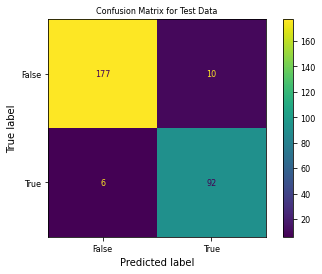

In [19]:
clf = LogisticRegression(random_state=42)
clf.fit(feature_set_skb, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_skb, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_skb)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"SKB_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_skb, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf, X_test_skb, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Method 2: Feature ranking with recursive feature elimination and cross-validated selection of the best number of features <a class="anchor" id="rfecv"></a>

[RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)
[RFECV](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html)

Note: I started by trying RFE, with both a Logistic Regression Model and a Random Forest Model. 

RFE was not a good fit for this data set. All features are ranked 1. the following are RFECV results.

In [20]:
clf = LogisticRegression(random_state=42)
rfecv_clf_selector = RFECV(estimator=clf ,step=1, cv=5)
rfecv_clf_feature_set = rfecv_clf_selector.fit_transform(X_train,y_train)

In [75]:
%store rfecv_clf_feature_set

Stored 'rfecv_clf_feature_set' (ndarray)


In [21]:
names = X.columns[rfecv_clf_selector.get_support()]
scores = rfecv_clf_selector.ranking_[rfecv_clf_selector.get_support()]
names_scores = list(zip(names, scores))
rfecv_clf = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfecv_clf.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean radius,1
1,mean area,1
2,mean compactness,1
3,mean concavity,1
4,mean concave points,1
5,radius error,1
6,area error,1
7,fractal dimension error,1
8,worst radius,1
9,worst texture,1


In [22]:
rfecv_clf.shape

(16, 2)

In [23]:
print('Optimal number of features: {}'.format(rfecv_clf_selector.n_features_))

Optimal number of features: 16


In [24]:
rf = RandomForestClassifier(random_state=42)  
rfecv_selector = RFECV(estimator=rf ,step=1, cv=5) #add scoring ROCAUC
rfecv_feature_set = rfecv_selector.fit_transform(X_train,y_train)

In [25]:
names = X.columns[rfecv_selector.get_support()]
scores = rfecv_selector.ranking_[rfecv_selector.get_support()]
names_scores = list(zip(names, scores))
rfecv_df = pd.DataFrame(data = names_scores, columns=['Features', 'Rank'])
rfecv_df.sort_values(by='Rank', ascending= False)

,Features,Rank
0,mean radius,1
1,mean texture,1
22,worst symmetry,1
21,worst concave points,1
20,worst concavity,1
19,worst compactness,1
18,worst smoothness,1
17,worst area,1
16,worst perimeter,1
15,worst texture,1


In [26]:
rfecv_df.shape

(24, 2)

In [27]:
print('Optimal number of features: {}'.format(rfecv_selector.n_features_))

Optimal number of features: 24


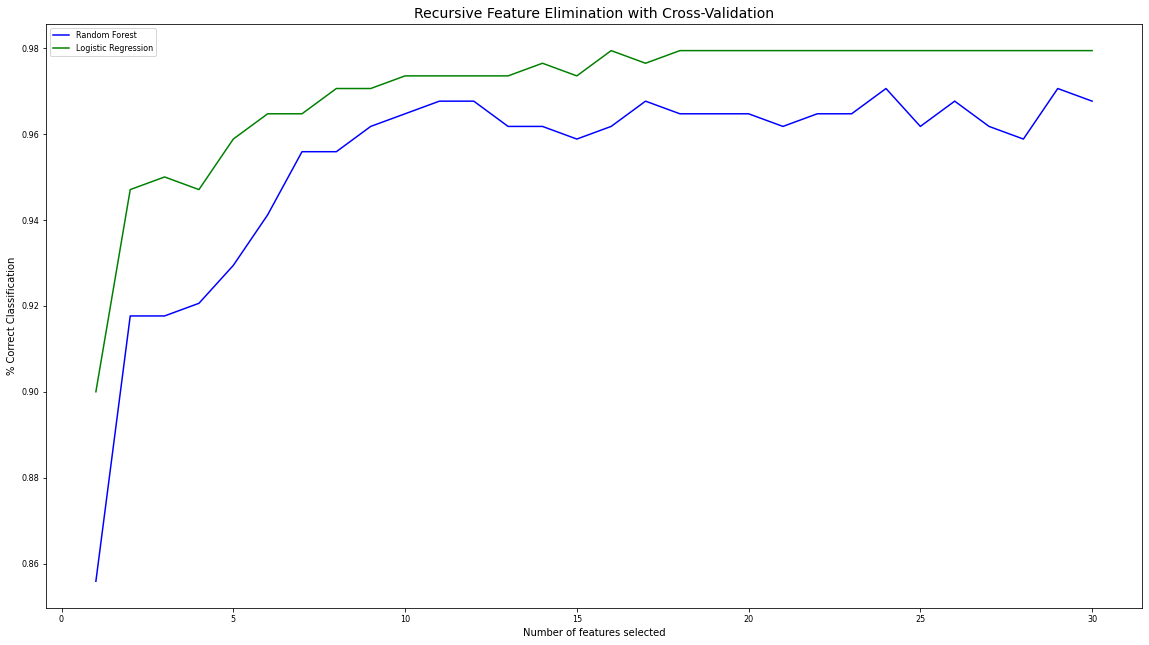

In [71]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation',fontsize=14)
plt.xlabel('Number of features selected')
plt.ylabel('% Correct Classification')
plt.plot(range(1, len(rfecv_selector.grid_scores_) + 1), rfecv_selector.grid_scores_, color='blue', label='Random Forest')
plt.plot(range(1, len(rfecv_clf_selector.grid_scores_) + 1), rfecv_clf_selector.grid_scores_, color='green', label='Logistic Regression')
plt.legend()
plt.tight_layout()
#plt.savefig('rfecv_feat_final.png') 
plt.show()

Of the two models, the Logistic Regression did best. I will test it out.

In [29]:
X_test_rfecv = rfecv_clf_selector.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"SelectKBest Test Data: {X_test_rfecv.shape}")

Baseline Test Data: (285, 30)
SelectKBest Test Data: (285, 16)


In [76]:
%store X_test_rfecv

Stored 'X_test_rfecv' (ndarray)


Accuracy on test data: 0.98
ROC AUC: 99.77081741787623%


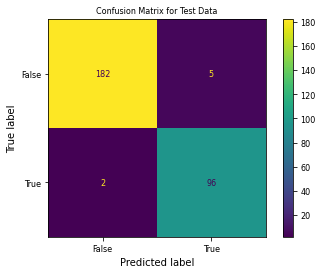

In [30]:
clf = LogisticRegression(random_state=42)
clf.fit(rfecv_clf_feature_set, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfecv, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfecv)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"RFECV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfecv, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_rfecv, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Method 3: Lasso <a class="anchor" id="Lasso"></a>

In [31]:
estimator = LassoCV(cv=5,random_state=42)
sfm = SelectFromModel(estimator)
sfm_feature_set = sfm.fit_transform(X_train, y_train)

In [77]:
%store sfm_feature_set

Stored 'sfm_feature_set' (ndarray)


In [32]:
X_test_lasso = sfm.transform(X_test)

print(f"Baseline Test Data: {X_test.shape}")
print(f"Lasso Test Data: {X_test_lasso.shape}")

Baseline Test Data: (285, 30)
Lasso Test Data: (285, 22)


In [78]:
%store X_test_lasso

Stored 'X_test_lasso' (ndarray)


Accuracy on test data: 0.98
ROC AUC: 99.72170686456401%


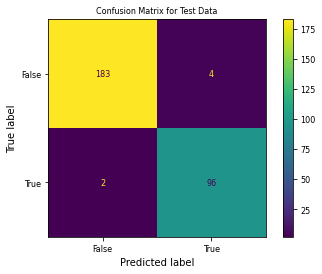

In [33]:
clf = LogisticRegression(random_state=42)
clf.fit(sfm_feature_set, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_lasso, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_lasso)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"LassoCV_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_lasso, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_lasso, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

### Mean Feature Set <a class="anchor" id="mean"></a>

In [34]:
X_train_mean = pd.DataFrame(X_train, columns = X.columns)
X_test_mean = pd.DataFrame(X_test, columns = X.columns)

In [35]:
print(X_train_mean.shape)
print(X_test_mean.shape)

(340, 30)
(285, 30)


In [36]:
#X_mean = pd.DataFrame(load_breast_cancer().data)
#X_mean.columns = load_breast_cancer().feature_names
#X_mean.columns

X_train_mean.drop(columns=['radius error', 'texture error','perimeter error','area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], inplace=True)

X_train_mean.shape

(340, 10)

In [37]:
X_test_mean.drop(columns=['radius error', 'texture error','perimeter error','area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'], inplace=True)

X_test_mean.shape

(285, 10)

In [80]:
%store X_train_mean

Stored 'X_train_mean' (DataFrame)


In [81]:
%store X_test_mean

Stored 'X_test_mean' (DataFrame)


#### Least Correlated Feature Set  <a class="anchor" id="less"></a>

In [38]:
X_train_clean = pd.DataFrame(X_train, columns = X.columns)
X_test_clean = pd.DataFrame(X_test, columns = X.columns)

In [39]:
print(X_train_clean.shape)
print(X_test_clean.shape)

(340, 30)
(285, 30)


In [40]:
X_train_clean.drop(columns=['worst smoothness', 'worst perimeter', 'mean area', 'mean concavity', 'worst concave points', 'area error', 'worst area', 'worst radius', 'worst texture', 'worst compactness', 'mean perimeter', 'worst concavity', 'perimeter error', 'mean concave points'], inplace=True)

X_train_clean.shape

(340, 16)

In [41]:
#X_clean = pd.DataFrame(load_breast_cancer().data)
#X_clean.columns = load_breast_cancer().feature_names
#X_clean.shape

X_test_clean.drop(columns=['worst smoothness', 'worst perimeter', 'mean area', 'mean concavity', 'worst concave points', 'area error', 'worst area', 'worst radius', 'worst texture', 'worst compactness', 'mean perimeter', 'worst concavity', 'perimeter error', 'mean concave points'], inplace=True)

X_test_clean.shape

(285, 16)

In [82]:
%store X_train_clean

Stored 'X_train_clean' (DataFrame)


In [83]:
%store X_test_clean

Stored 'X_test_clean' (DataFrame)


### Method 6: Random Forest Feature Importance <a class="anchor" id="rffi"></a>

In [42]:
y.value_counts()

False    357
True     212
dtype: int64

In [43]:
data = load_breast_cancer()

In [44]:
#Converting df to numpy array
X = X.to_numpy()
y = y.to_numpy()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

In [87]:
y_train.shape

(284, 1)

In [46]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(rf.score(X_test, y_test)))

Accuracy on test data: 0.96


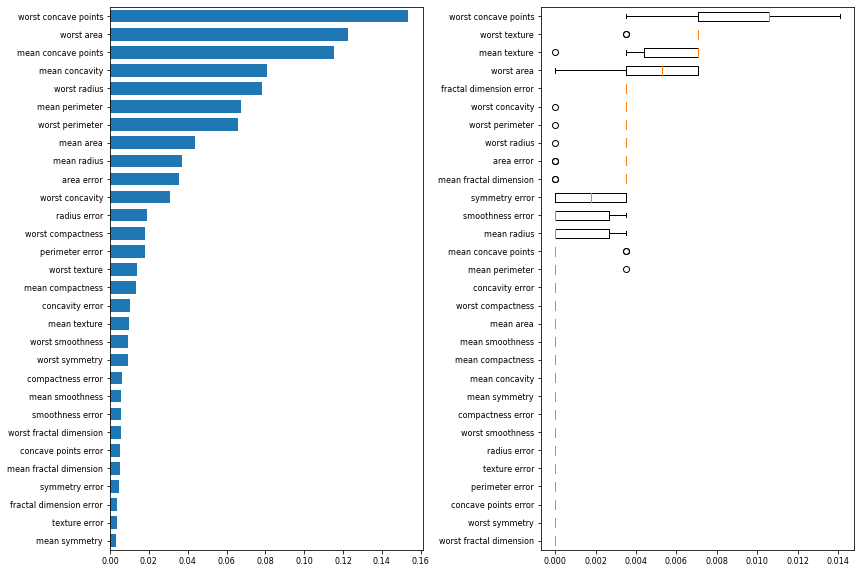

In [47]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf.feature_importances_)
tree_indices = np.arange(0, len(rf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         rf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
#plt.savefig('rfi_feat.png') 
plt.show()

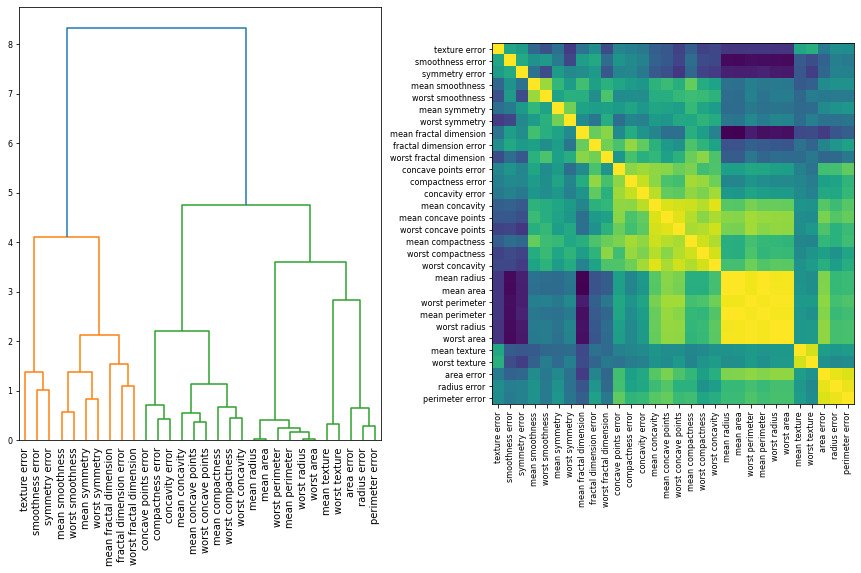

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
#plt.savefig('rfi_feat2.png') 
plt.show()

In [49]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_rfi = X_train[:, selected_features]
X_test_rfi = X_test[:, selected_features]


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rfi, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      rf.score(X_test_rfi, y_test)))

Accuracy on test data with features removed: 0.95


In [89]:
y_train.shape

(284, 1)

In [88]:
X_train_rfi.shape

(284, 14)

In [84]:
#%store X_train_rfi

Stored 'X_train_rfi' (ndarray)


In [85]:
#%store X_test_rfi

Stored 'X_test_rfi' (ndarray)


Accuracy on test data: 0.91
ROC AUC: 97.12976099530722%


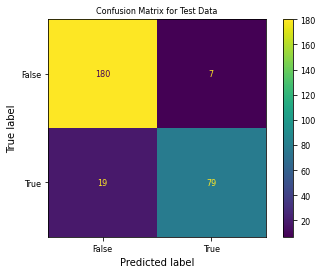

In [50]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train_rfi, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_rfi, y_test)))

# Accuray On Test Data
probs = clf.predict_proba(X_test_rfi)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

fs_dict.update({"RF_Feat_Importance_LogReg":[f"ROC AUC: {roc_auc*100}%",f"Accuracy:{clf.score(X_test_rfi, y_test)}"]})

print(f"ROC AUC: {roc_auc*100}%")
plot_confusion_matrix(clf,X_test_rfi, y_test)
plt.title("Confusion Matrix for Test Data")
plt.show()

In [51]:
data.feature_names[selected_features]

array(['mean radius', 'mean texture', 'mean smoothness',
       'mean compactness', 'mean concavity', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'smoothness error', 'compactness error', 'symmetry error',
       'fractal dimension error', 'worst fractal dimension'], dtype='<U23')

In [52]:
feat_sel_df = pd.DataFrame(fs_dict)

In [53]:
feat_sel_df = feat_sel_df.T

In [54]:
feat_sel_df.columns =['ROC AUC', 'Accuracy']

In [55]:
feat_sel_df

,ROC AUC,Accuracy
Baseline_LogReg,ROC AUC: 99.73807704900142%,Accuracy:0.9859649122807017
SKB_LogReg,ROC AUC: 99.1542071374004%,Accuracy:0.9438596491228071
RFECV_LogReg,ROC AUC: 99.77081741787623%,Accuracy:0.9754385964912281
LassoCV_LogReg,ROC AUC: 99.72170686456401%,Accuracy:0.9789473684210527
RF_Feat_Importance_LogReg,ROC AUC: 97.12976099530722%,Accuracy:0.9087719298245615


In [56]:
feat_sel_df['ROC AUC'].str.replace('ROC AUC:', '')
feat_sel_df['ROC AUC'].str.replace('%', '')

Baseline_LogReg              ROC AUC: 99.73807704900142
SKB_LogReg                    ROC AUC: 99.1542071374004
RFECV_LogReg                 ROC AUC: 99.77081741787623
LassoCV_LogReg               ROC AUC: 99.72170686456401
RF_Feat_Importance_LogReg    ROC AUC: 97.12976099530722
Name: ROC AUC, dtype: object

In [57]:
feat_sel_df.Accuracy.str.replace('Accuracy:', '')

Baseline_LogReg              0.9859649122807017
SKB_LogReg                   0.9438596491228071
RFECV_LogReg                 0.9754385964912281
LassoCV_LogReg               0.9789473684210527
RF_Feat_Importance_LogReg    0.9087719298245615
Name: Accuracy, dtype: object

In [58]:
#features= pd.DataFrame(load_breast_cancer().feature_names)

In [59]:
#features.columns = ['features']


In [60]:
#features = features.merge(SelectKbest_df.Features,how='left', left_on='features', right_on="Features")

In [61]:
#features.columns = ['features','SelectKbest']

In [62]:
#rfecv_clf.Features

In [63]:
#features = features.merge(rfecv_clf.Features,how='left', left_on='features', right_on="Features")

In [64]:
#features.columns = ['features','SelectKbest','RFECV']

In [65]:
#Lasso_df = pd.DataFrame(combo_df, columns=["Lasso"])

In [66]:
#combo_df = combo_df.merge(Lasso_df,how='left', left_on=0, right_on='Lasso')


In [67]:
#rfi_df = pd.DataFrame(data.feature_names[selected_features], columns=['selected_features'])

In [68]:
#combo_df = combo_df.merge(rfi_df,how='left', left_on=0, right_on='selected_features')


In [69]:
#combo_df.columns = ['Baseline', 'SelectKbest','RFECV', 'Lasso','RF Feat Importance'] 

In [70]:
#combo_df.to_excel('combo_df.xls')